# SciPy
![SciPy](https://raw.githubusercontent.com/scipy/scipy-sphinx-theme/master/_static/scipyshiny_small.png)

- Uses numpy as its core
- Numerical methods for:
    + integration
    + solving differential equations
    + optimizing, minimizing 
    + root finding
    + fast fourier transforms
- Contains the CODATA values for many constants of nature
- Mostly build as wrappers around time-proven fortran libraries (fftpack, lapack, fitpack)

# Table of Contents

1. [Physical constants](#physical_constants)
2. [Optimize](#optimize)
    * [General least-squares fitting using `curve_fit`](#curve_fit)
        - [Exercise 1](#exercise_1)
        - [Providing uncertainties and initial guesses](#uncertainties_guesses)
    * [Function minimization using `minimize`](#minimize)
        - [Unbinned likelihood fits](#likelihood)
        - [Exercise 2](#exercise_2)
3. [Fast Fourier Transforms (FFTs)](#fft)
4. [Integration](#integration)
    * [Function integration](#function_integration)
    * [Sample integration](#sample_integration)
        - [Exercise 3](#exercise_3)
5. [Interpolation](#interpolation)
    * [Linear interpolation](#linear_interpolation)
    * [Cubic spline interpolation](#spline_interpolation)
    * [Exercise 4](#exercise_4)
6. [Stats](#stats)
    * [Probability distributions](#stats_distributions)
        - [Continuous distributions](#continuous_distributions)
        - [Discrete distributions](#discrete_distributions)
        - [Multivariate distributions](#multivariate_distributions)
    * [Statistical functions](#statistical_functions)
    * [Example](#stats_example)
    * [Exercise 5](#exercise_5)
7. [Special Functions](#special_functions)
    * [Signal filtering](#filtering)
        - [Exercise 6](#exercise_6)
    * [Bessel functions](#bessel)
    * [Error function and Gaussian CDF](#erf)
    * [Orthogonal Polynomials](#ortho_polys)
        - [Exercise 7](#exercise_7)

# Notebook Setup (run me first!)

In [1]:
import scipy as sp
import numpy as np

# we will need to plot stuff later
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

<a id=physical_constants></a>
# Physical constants

In [2]:
import scipy.constants as const
const.epsilon_0

8.8541878128e-12

In [3]:
# convert temperatures:
const.convert_temperature(100, old_scale='C', new_scale='K')

373.15

In [ ]:
# more constants (including units and errors)!

for k, v in const.physical_constants.items():
    print(k, ':', v)
    

In [ ]:
const

In [8]:
val, unit, uncertainty = const.physical_constants['muon mass energy equivalent in MeV']

val, unit, uncertainty

(105.6583755, 'MeV', 2.3e-06)

<a id=optimize></a>
# Optimize

<a id=curve_fit></a>
## General least-squares fitting using `curve_fit`

Non-linear least-squares with Levenberg-Marquardt numerical minimization.

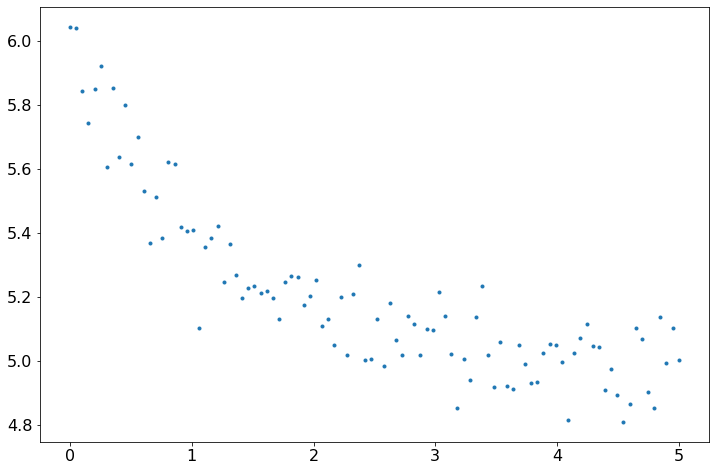

In [9]:
a = -1
b = 5
c = 2

def f(x, a, b):
    return np.exp(a * x) + b

def g(x, a, b, c):
    return a*x**2 + b*x + c

x = np.linspace(0, 5, 100)
y = f(x, a, b) + np.random.normal(0, 0.1, 100)

plt.plot(x, y, '.', label='data')

In [10]:
from scipy.optimize import curve_fit

params, covariance_matrix = curve_fit(g, x, y)

uncertainties = np.sqrt(np.diag(covariance_matrix))
error = ((y - g(x, *params))**2).sum()

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))
print('c = {:5.2f} ± {:.2f}'.format(params[2], uncertainties[2]))
print('error: {}'.format(error))


a =  0.06 ± 0.01
b = -0.46 ± 0.03
c =  5.86 ± 0.03
error: 1.059522520676669


In [11]:
print(covariance_matrix)

[[ 3.02335338e-05 -1.51167669e-04  1.24700603e-04]
 [-1.51167669e-04  8.07230105e-04 -7.51982425e-04]
 [ 1.24700603e-04 -7.51982425e-04  9.44765162e-04]]


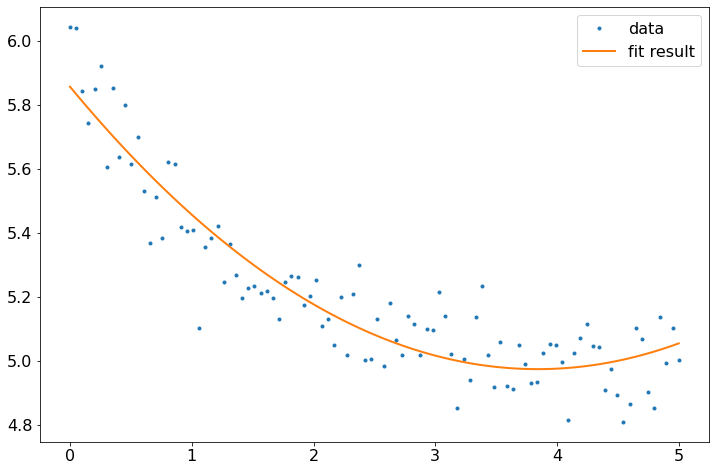

In [12]:
plt.plot(x, y, '.', label='data')
plt.plot(x, g(x, *params), label='fit result')
plt.legend();

## Non-linear least squares with boundaries: `least_squares`

We can achieve the same result with the `least_squares` method that allows also constrained optimization.

Some reformatting is needed

In [13]:
from scipy.optimize import least_squares

def model(a, x):
    return a[0]*x**2 + a[1]*x + a[2]

def fun(a, x, y):
    return model(a, x) - y
    
a0 =  [1., 1., 1.]
res = least_squares(fun, a0, args=(x, y), method='lm')
params = res.x
covariance_matrix = np.linalg.inv(res.jac.T.dot(res.jac))

uncertainties = np.sqrt(np.diag(covariance_matrix)) # I didn't manage to reproduce the uncertainties
error = ((y - g(x, *res.x))**2).sum()

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))
print('c = {:5.2f} ± {:.2f}'.format(params[2], uncertainties[2]))
print('error: {}'.format(error))


a =  0.06 ± 0.05
b = -0.46 ± 0.27
c =  5.86 ± 0.29
error: 1.059522520676669


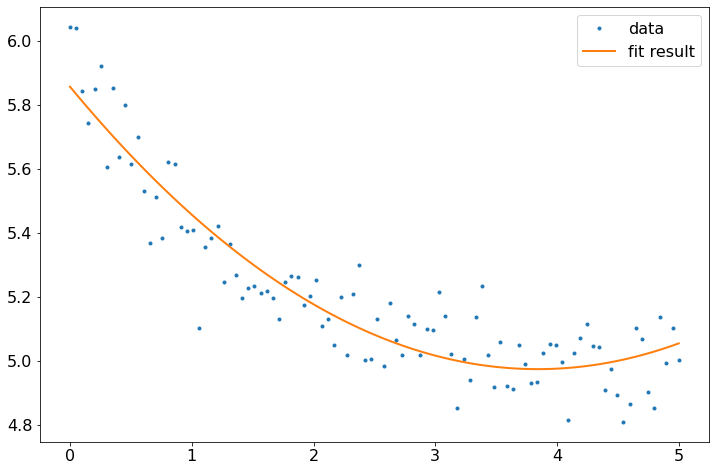

In [14]:
plt.plot(x, y, '.', label='data')
plt.plot(x, g(x, *params), label='fit result')
plt.legend();

We can apply constraints to the variables

In [40]:
bounds=[[0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]]
a0 =  [1., 1., 1.]
res = least_squares(fun, a0, args=(x, y), bounds=bounds, loss='soft_l1')
params = res.x
covariance_matrix = np.linalg.inv(res.jac.T.dot(res.jac))

uncertainties = np.sqrt(np.diag(covariance_matrix))
error = ((y - g(x, *res.x))**2).sum()

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))
print('c = {:5.2f} ± {:.2f}'.format(params[2], uncertainties[2]))
print('error: {}'.format(error))


a =  0.06 ± 0.05
b = -0.46 ± 0.27
c =  5.86 ± 0.30
error: 1.0595230841436192


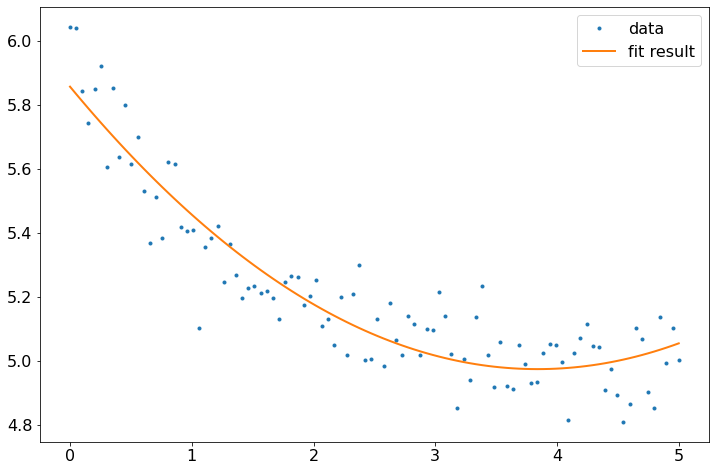

In [41]:
plt.plot(x, y, '.', label='data')
plt.plot(x, g(x, *params), label='fit result')
plt.legend();

## Linear regression with `curve_fit`

/data/jupyter/software/miniconda_py39_4.10.3/envs/jupyterhub_0.4/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


error: 2.350137254302637


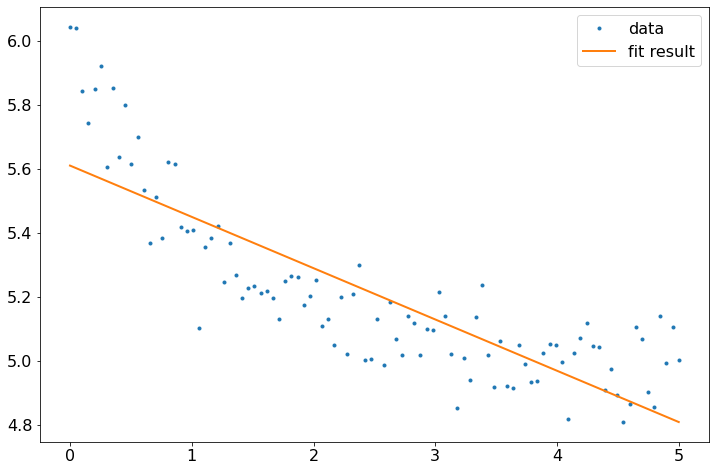

In [42]:
# We can use this method to do a linear regression

def f_linear(x, a, b, c):
    return a*x + b

l_params, l_covariance_matrix = curve_fit(f_linear, x, y)
l_uncertainties = np.sqrt(np.diag(l_covariance_matrix))

plt.plot(x, y, '.', label='data')
plt.plot(x, f_linear(x, *l_params), label='fit result')
plt.legend();

error = ((y - f_linear(x, *l_params))**2).sum()
print('error: {}'.format(error))

In [43]:
# We can check that the result is the same as the one obtained from the linear regression method

from scipy.stats import linregress

print('With curve_fit')
print('\ta = {:5.2f} ± {:.2f}'.format(l_params[0], l_uncertainties[0]))
print('\tb = {:5.2f} ± {:.2f}'.format(l_params[1], l_uncertainties[1]))

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('With linregress')
print('\ta = {:5.2f}'.format(slope))
print('\tb = {:5.2f}'.format(intercept))


With curve_fit
	a = -0.16 ± inf
	b =  5.61 ± inf
With linregress
	a = -0.16
	b =  5.61


<a id=exercise_1></a>
## Exercise 1

Use the `curve_fit` function to fit a quadratic polynomial function to the data, plot the result and compare the error with the previous fits.

<a id=uncertainties_guesses></a>
### Providing uncertainties and initial guesses

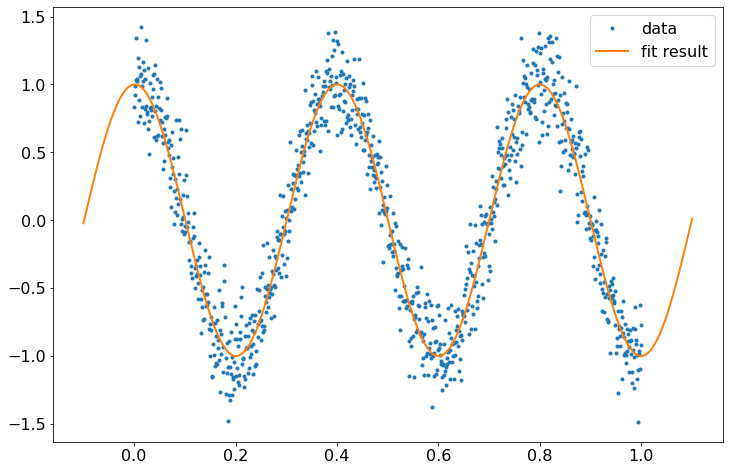

In [45]:
x = np.linspace(0, 1, 1000)
def f(x, a, b):
    return np.sin(a * x + b)

y = f(x, 5 * np.pi, np.pi / 2) 
yerr = np.full_like(y, 0.2)
noise = np.random.normal(0, yerr, 1000)
y += noise


#params, covariance_matrix = curve_fit(f, x, y)

params, covariance_matrix = curve_fit(
   f, x, y,
   p0=[15, 2],
)

# params, covariance_matrix = curve_fit(
#     f, x, y,
#     p0=[15, 1.5],
#     sigma=yerr,
#     absolute_sigma=True,
# )


# plot the stuff

x_plot = np.linspace(-0.1, 1.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend();

<a id=minimize></a>
## Unconstraint function minimization using `minimize`

We define a function with two local minimums

In [47]:
MIN_1 = np.array([2, 1])
MIN_2 = np.array([-2, 3])

def f(x, h, x1):
    return h*np.exp(-((x - x1)**2).sum(axis=-1))

def g(x):
    return -f(x, 1, MIN_1) - f(x, 2, MIN_2)

In [48]:
XLIM = [-5, 5]
YLIM = [-2.5, 7.5]
x = np.linspace(*XLIM, 100)
y = np.linspace(*YLIM, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = g(pos)

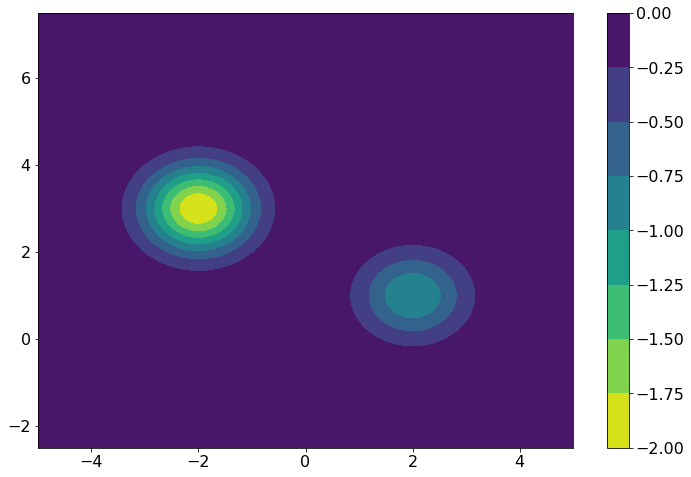

In [49]:
plt.contourf(X, Y, Z, cmap='viridis_r')
plt.colorbar()

We will try to find the minimum

In [50]:
from scipy.optimize import minimize

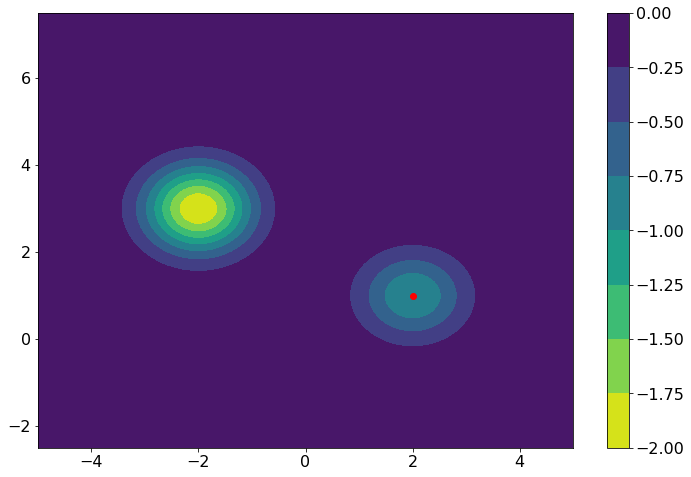

In [51]:
x0 = (3, 0)
r = minimize(g, x0=x0)

plt.contourf(X, Y, Z, cmap='viridis_r')
plt.colorbar()
plt.plot([r.x[0]], [r.x[1]], 'ro-')

We haven't found the absolute minimum

Let's see the path followed by minimize

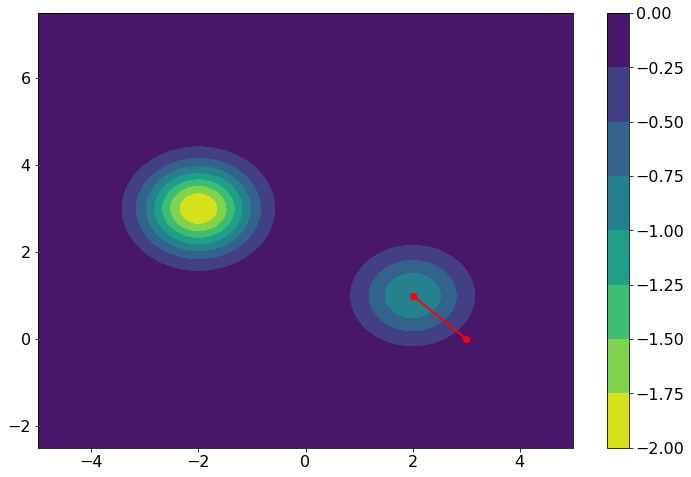

In [55]:
global min_path

min_path = [(3., 0.)]

def store_path(x):
    min_path.append(x)

r = minimize(g, x0=min_path[0], callback=store_path, tol=1e-20, method='CG',
             options={'gtol': 1e-10, 'maxiter':100, 'eps': 1e-9})

plt.contourf(X, Y, Z, cmap='viridis_r')
plt.colorbar()
plt.plot([p[0] for p in min_path], [p[1] for p in min_path], 'ro-')

In [56]:
r

     fun: -1.0000000041223076
     jac: array([0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 3
    njev: 13
  status: 0
 success: True
       x: array([1.99999998, 1.00000001])

Let's see where do different initial guesses lead to

In [57]:
x_range = np.linspace(-8, 8, 33)
y_range = np.linspace(-4, 10, 29)

X, Y = np.meshgrid(x_range, y_range)

In [58]:
x0_arr = np.vstack([X.reshape(-1), Y.reshape(-1)]).T

In [62]:
def minimize_g(x):
    return minimize(g, x0=x, method='CG').x

result = np.apply_along_axis(minimize_g, 1, x0_arr) # providing an initial guess is mandatory

In [63]:
s1 = np.isclose(result, MIN_1)
s2 = np.isclose(result, MIN_2)
s3 = ~(np.logical_or(s1, s2))

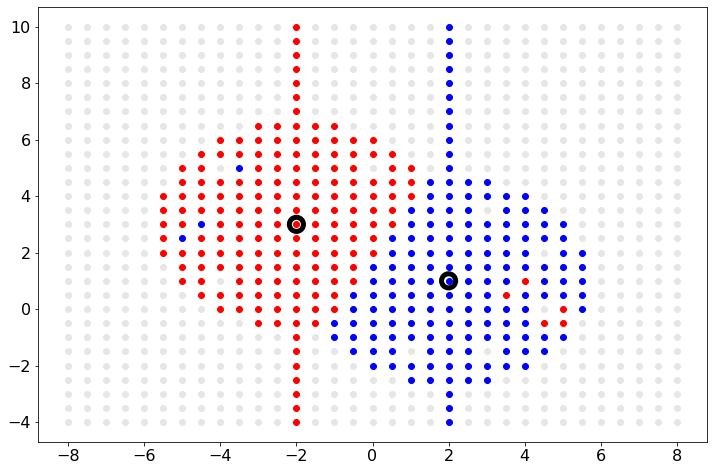

In [64]:
plt.plot(x0_arr[s1[:, 0], 0], x0_arr[s1[:, 0], 1], 'bo')
plt.plot(x0_arr[s2[:, 0], 0], x0_arr[s2[:, 0], 1], 'ro')
plt.plot(x0_arr[s3[:, 0], 0], x0_arr[s3[:, 0], 1], c='0.9', marker='o', linestyle='')
plt.scatter(*MIN_1, s=200, facecolors='None', ec='k', lw=5)
plt.scatter(*MIN_2, s=200, facecolors='None', ec='k', lw=5)

<a id=likelihood></a>
### Unbinned likelihood fits

Example: an unbinned negative log-likelihood fit for a poissonian distribution

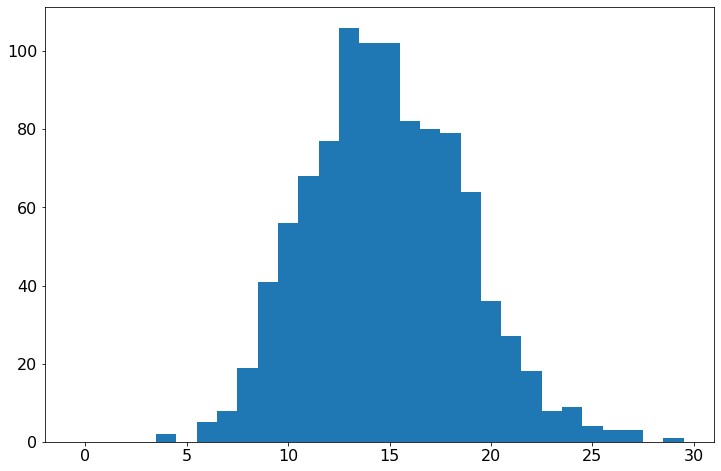

In [65]:
lambda_ = 15
k = np.random.poisson(lambda_, 1000)

# make sure to use bins of integer width, centered around the integer
bin_edges = np.arange(0, 31) - 0.5

plt.hist(k, bins=bin_edges);

Poisson pdf:

$$ 
f(k, \lambda) = \frac{\lambda^k}{k!} \mathrm{e}^{-\lambda}
$$

So the likelihood is:

$$
\mathcal{L} = \prod_{i=0}^{N} \frac{\lambda^{k_i}}{k_i!} \mathrm{e}^{-\lambda}
$$

It's often easier to minimize $-\log(\mathcal{L})$, let's see:

$$
-\log(\mathcal{L}) = - \sum_{i=0}^{N}\bigl( k_i \log(\lambda) - \log{k_i!} - \lambda \bigr)
$$

We are interested in the minimum relative to $\lambda$, so we dismiss constant term not concerning $\lambda$ 
$$
-\log(\mathcal{L}) = \sum_{i=0}^{N}\bigl( \lambda - k_i \log(\lambda) \bigr)   
$$

This looks indeed easier to minimize than the likelihood.

In [66]:
def negative_log_likelihood(lambda_, k):
    return np.sum(lambda_ - k * np.log(lambda_))

result = minimize(
    negative_log_likelihood,
    x0=(10, ),   # initial guess
    args=(k, ),  # additional arguments for the function to minimize
)

result

print('True λ = {}'.format(lambda_))
print('Fit: λ = {:.2f} ± {:.2f}'.format(result.x[0], np.sqrt(result.hess_inv[0, 0])))

True λ = 15
Fit: λ = 14.86 ± 0.08


* minimize has lots of options for different minimization algorithms
* Also able to respect bounds and constraints (with certain algorithms)
* It is worth to write down you problems and simplify the (log)Likelihood as much as possible

<a id=exercise_2></a>
### Exercise 2

Do the same to estimate the parameters of a gaussian distribution.

Generate a sample of a normal distribution with $\mu = 10$ and $\sigma = 6$

pdf:

$$
f(x, \mu, \sigma) =  \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}}
$$

Minimize the negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}}  \bigr)
$$

You can make use of the `norm.rvs` and `norm.pdf` functions to generate the sample and define the function to be minimized.

In [67]:
from scipy.stats import norm

<a id=fft></a>
# Fast Fourier Transforms (FFTs)

In [68]:
freq1 = 5
freq2 = 50

t = np.linspace(0, 1, 1024*10)
y = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)

# add some white noise
noisy_y = y + np.random.normal(np.full_like(y, 0.), 5)

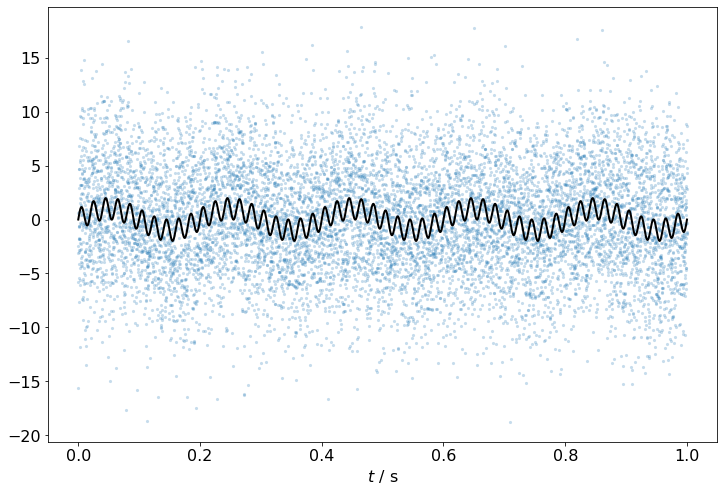

In [69]:
plt.scatter(t, noisy_y, s=10, alpha=0.25, lw=0)
plt.plot(t, y, c='k')
plt.xlabel(r'$t \ /\ \mathrm{s}$');

In [70]:
from scipy import fftpack

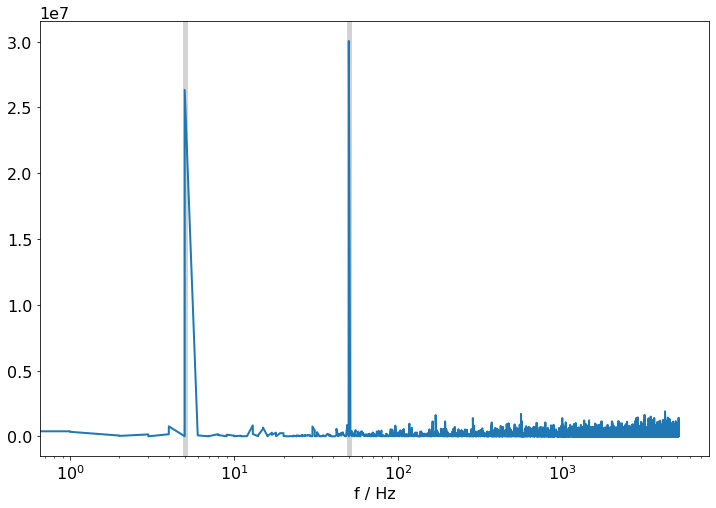

In [71]:
z = fftpack.rfft(noisy_y)
f = fftpack.rfftfreq(len(t), t[1] - t[0])

plt.axvline(freq1, color='lightgray', lw=5)
plt.axvline(freq2, color='lightgray', lw=5)

plt.plot(f, z**2)

plt.xlabel('f / Hz')
plt.xscale('log')
# plt.yscale('log');

<a id=integration></a>
# Integration

Scipy integration routines are discussed in the [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). We will look at the two most common routines here.

<a id=function_integration></a>
## Function integration

`quad` is used to evaluate definite 1D numerical integrals using a technique from the Fortran library QUADPACK.

For example, assume we want to integrate a quadratic polynomial $f(x) = 3x^2 + 6x - 9$ over an interval $x \in [0, 5]$. Analytically, the answer is:

$$ \int_0^5 3x^2 + 6x - 9 \ dx = \left[ x^3 + 3x^2 - 9x \right]_{x = 0}^{x = 5} = 155 $$

In [72]:
from scipy.integrate import quad

def f(x):
    return 3*x**2 + 6*x - 9

quad(f, 0, 5)

(155.0, 1.832332444897697e-12)

The first parameter `quad` returns is the answer; the second is an estimate of the absolute error in the result.

For 2D, 3D, or n-dimensional integrals , use `dblquad`, `tplquad`, or `nquad`, respectively.

For some more interesting functions, Scipy's other function integration routines might be helpful:
* `quadrature` : [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)
* `romberg` : [Romberg integration](https://en.wikipedia.org/wiki/Romberg%27s_method)

For example, consider the $\mathrm{sinc}$ function:

$$
\mathrm{sinc}(x) \equiv
\begin{cases} 
1 & x = 0 \\
\sin(x)/x & \mathrm{otherwise}
\end{cases}
$$

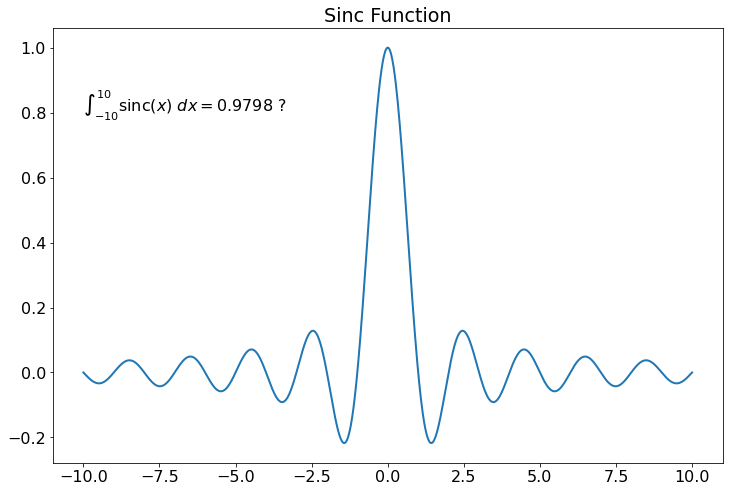

In [73]:
x = np.linspace(-10, 10, 1000)
y = np.sinc(x)
plt.plot(x, y)
plt.title('Sinc Function')

res = quad(np.sinc, -10, 10)

plt.text(-10, 0.8, r'$ \int_{{-10}}^{{10}} \mathrm{{sinc}}(x) \ dx = {result:.4f}$ ?'.format(result=res[0]));

`quad` used to struggle with `sinc` but it has been improved and it is no longer the case. Now it provides an accurate result.

<a id=sampleintegration></a>
## Sample integration

If you have a collection of points that you want to integrate, you could use an [interpolation function](#interpolation) and pass it to `quad`. A better alternative is to use the purpose-built functions `trapz`, `romb`, and `simps`.

We will consider the $\mathrm{sinc}$ function again as an example. The most naive (and surprisingly robust) integration method is using the trapazoid rule, which is implemented in `trapz`:

In [74]:
from scipy.integrate import trapz

# 50 grid points
x1 = np.linspace(-10, 10, 51)
y1 = np.sinc(x1)
print('  50 points:', trapz(y1, x1))   # note the order of the arguments: y, x

# 1000 grid points
x = np.linspace(-10, 10, 10000)
y = np.sinc(x)
print('1000 points:', trapz(y, x))

  50 points: 0.9825154556706699
1000 points: 0.9797764089878029


<a id=exercise_3></a>
### Exercise 3

Apply the `trapz` function to calculate:

$$
\int_{-4}^{4} \sqrt[3]{(1 - x^3)} dx
$$

**Hint** use the `np.cbrt` function

<a id=interpolation></a>
# Interpolation

<a id=linear_interpolation></a>
## Linear interpolation

Imagine you would like to interpolate between two points $(x_0, y_0)$ and $(x_1, y_1)$. You could do this by hand:

$$y(x) = y_0 + (x - x_0) \frac{y_1 - y_0}{x_1 - x_0}$$

Simple enough, but it is annoying to look up or derive the formula. Also, what if you want values less than $x_0$ to stay at the value of $y_0$, and likewise for values greater than $x_1$? Then you need to add `if` statements, and check the logic, etc. Too much work.

Instead, there is a simple function for almost all of your interpolation needs: `interp1d`.

In [75]:
from scipy.interpolate import interp1d

x = (1, 2)
y = (5, 7)
print('Points:', list(zip(x, y)))

f = interp1d(x, y)
z = [1.25, 1.5, 1.75]
print('Interpolation:', list(zip(z, f(z))))

Points: [(1, 5), (2, 7)]
Interpolation: [(1.25, 5.5), (1.5, 6.0), (1.75, 6.5)]


Right now, if you try to use an x-coordinate outside of the interval $[x_0, x_1]$, a `ValueError` will be raised:

In [76]:
f(2.5)   # uncomment to run me

ValueError: A value in x_new is above the interpolation range.

This is because we haven't told `interp1d` how we want to handle the boundaries. This is done using the `fill_value` keyword argument. There are a few options:

1. Set values outside of the interval $[x_0, x_1]$ to a float.
2. Set values $< x_0$ to `below` and values $> x_1$ to `above` by passing a tuple, `(below, above)`.
3. Extrapolate points outside the interval by passing `extrapolate`.

We also need to tell `interp1d` not to raise a `ValueError` by setting the `bounds_error` keyword to `False`.

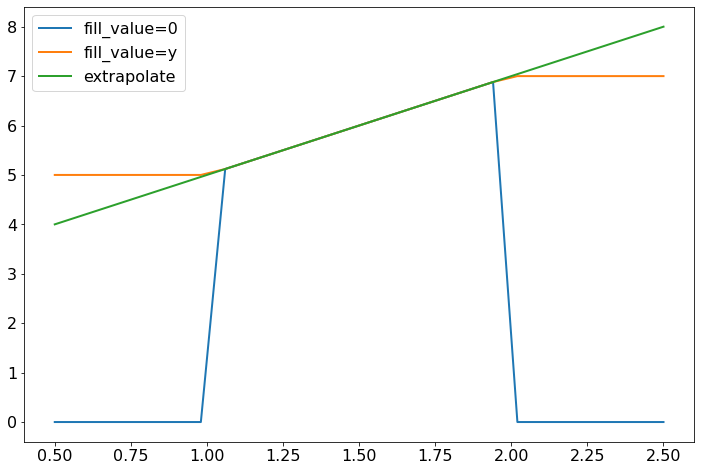

In [77]:
z = np.linspace(0.5, 2.5, 26)

f = interp1d(x, y, bounds_error=False, fill_value=0)
plt.plot(z, f(z), label='fill_value=0')

f = interp1d(x, y, bounds_error=False, fill_value=y)   # fill with endpoint values
plt.plot(z, f(z), label='fill_value=y')

f = interp1d(x, y, fill_value='extrapolate')   # bounds_error set to False automatically
plt.plot(z, f(z), label='extrapolate')

plt.legend()

<a id=spline_interpolation></a>
## Cubic spline interpolation

[Cubic splines](http://mathworld.wolfram.com/CubicSpline.html) are what are most commonly used when you want to interpolate between points *smoothly*.

Cubic spline interpolation is so common, it has its own method, `CubicSpline`, which produces generally better results.

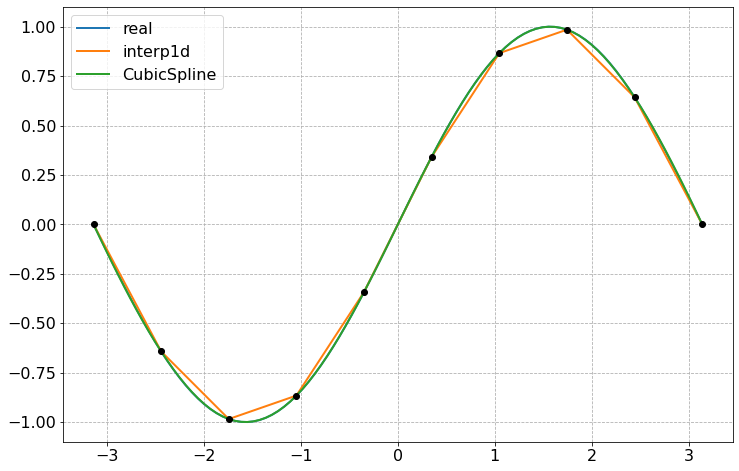

In [81]:
from scipy.interpolate import CubicSpline

# Generate a sample of the sinus function
sample_x = np.linspace(-np.pi, np.pi, 10)
sample_y = np.sin(sample_x)

# Sinus function
z = np.linspace(np.min(sample_x), np.max(sample_x), 100)
plt.plot(z, np.sin(z), label='real')

# 1D interpolation
f1 = interp1d(sample_x, sample_y)
plt.plot(z, f1(z), label='interp1d')

# The cubic spline
f2 = CubicSpline(sample_x, sample_y)
plt.plot(z, f2(z), label='CubicSpline')

plt.plot(sample_x, sample_y, 'ko')
plt.legend();
plt.grid(linestyle='--');

You can also interpolate on 2 and N dimensional spaces (with some restrictions).
See [the scipy docs on interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate)

<a id=exercise_4></a>
## Exercise 4

Interpolate the $sinc$ function we have already seen, using:
* two samples of 10 and 100 points
* linear interpolation and cubic splines
* on the [-10, 10] interval

<a id=stats></a>
# Stats

The scipy.stats module provides mainly:
* probability distributions: continuous, discrete and multivariate
* statistical functions such as statistics and tests

For further details you can check [the official documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [82]:
from scipy import stats

<a id=stats_distributions></a>
## Probability distributions

The scipy.stats module provides a very complete set of probability distributions.

There are three types of distributions:
* Continuous
* Discrete
* Multivariate

Each of the univariate types is inherited from the same class, so they all have a common API.

<a id=continuous_distributions></a>
### Continuos distributions

There are ~100 different continuous distributions. Some of the methods in the API:
* `cdf`: Cumulative Distribution Function
* `pdf`: Probability Density Function
* `rvs`: Random Variable Sample
* `ppf`: Percent Point Function (inverse of the CDF)
* `fit`: return MLE estimations of location, scale and shape, given a set of data

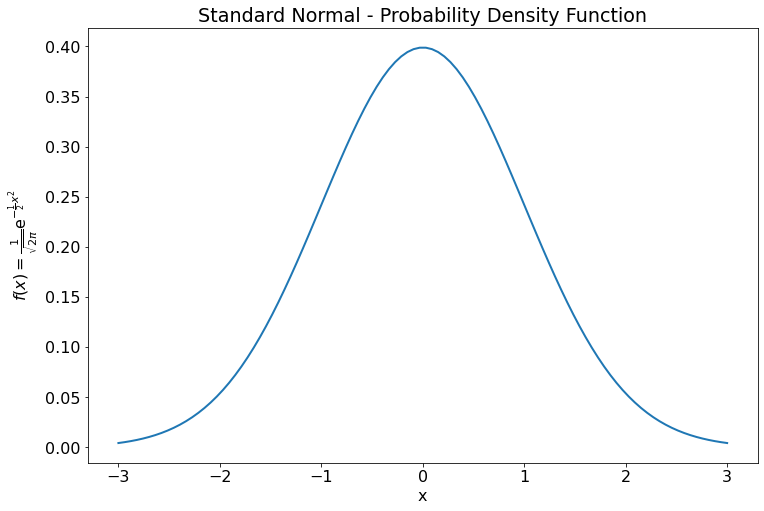

In [83]:
std_normal = stats.norm()

x = np.linspace(-3, 3, 100)
plt.plot(x, std_normal.pdf(x))
plt.title('Standard Normal - Probability Density Function')
plt.xlabel('x')
plt.ylabel(r'$ f(x) =  \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-\frac{1}{2} x^2}}$');

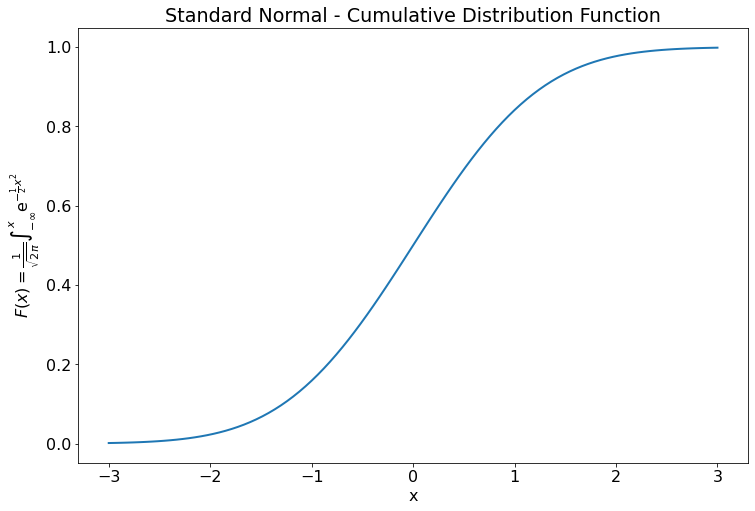

In [84]:
plt.plot(x, std_normal.cdf(x))
plt.title('Standard Normal - Cumulative Distribution Function')
plt.xlabel('x')
plt.ylabel(r'$ F(x) =  \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x}\mathrm{e}^{-\frac{1}{2} x^2}}$');

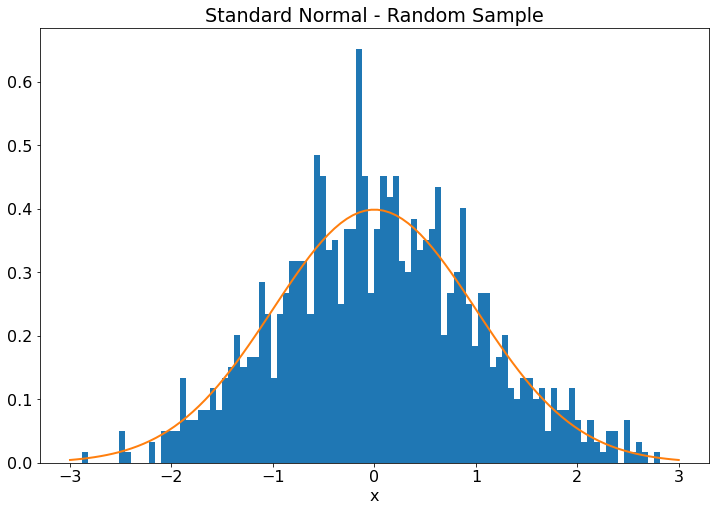

In [85]:
x_sample = std_normal.rvs(1000)
hist_result = plt.hist(x_sample, range=[-3, 3], bins=100, density=True)
x_plot = np.linspace(-3, 3, 100)
plt.plot(x_plot, std_normal.pdf(x_plot))
plt.title('Standard Normal - Random Sample')
plt.xlabel('x');

In [86]:
# Get the estimation of the mean and the standard deviation from a sample
stats.norm.fit(x_sample)

(0.03646835646726058, 0.9998279642689979)

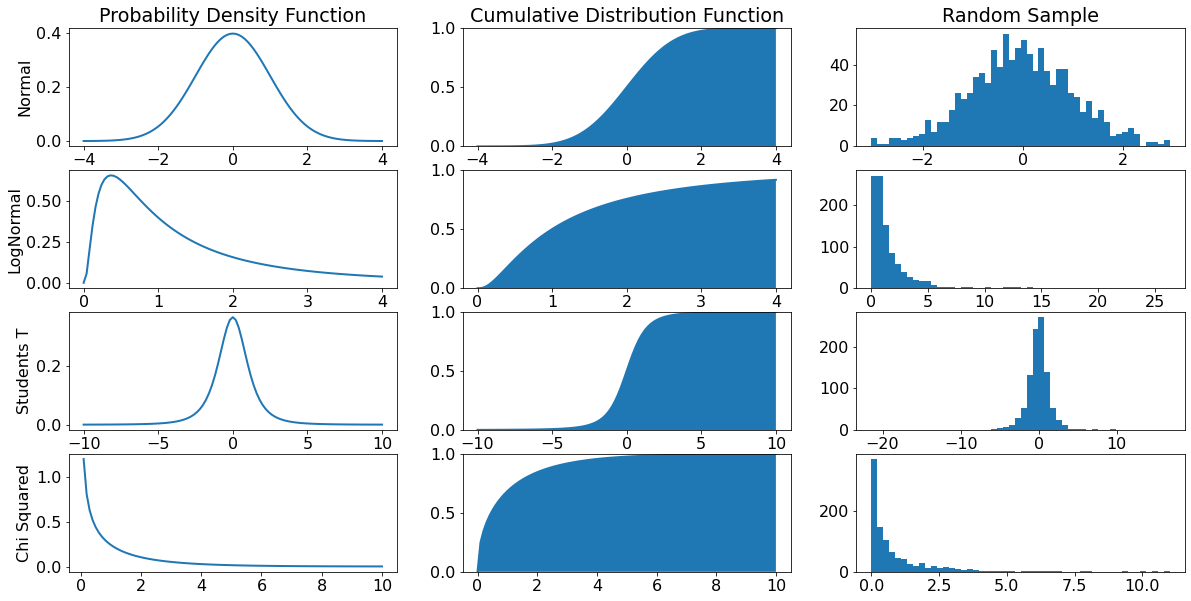

In [87]:
N_SAMPLES = 1000

# Name of the probability distribution, class, range of values to plot
pds = [('Normal', stats.norm(), (-4., 4.)), 
      ('LogNormal', stats.lognorm(1.), (0., 4.)),
      ('Students T', stats.t(3.), (-10., 10.)),
      ('Chi Squared', stats.chi2(1.), (0., 10.))]

n_pds = len(pds)
fig, ax_list = plt.subplots(n_pds, 3, figsize=(5.*n_pds, 10.))
for ind, elem in enumerate(pds):
    
    pd_name, pd_func, pd_range = elem

    x_range = np.linspace(*pd_range, 101)
    
    # Probability Density Function
    ax_list[ind, 0].plot(x_range, pd_func.pdf(x_range))
    ax_list[ind, 0].set_ylabel(pd_name)
    
    # Cumulative Distribution Function
    ax_list[ind, 1].plot(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].fill_between(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].set_ylim([0., 1.])
    
    # Random Variable Sample
    ax_list[ind, 2].hist(pd_func.rvs(size=N_SAMPLES), bins=50)
    
    if ind == 0:
        _ = ax_list[ind, 0].set_title('Probability Density Function')
        _ = ax_list[ind, 1].set_title('Cumulative Distribution Function')
        _ = ax_list[ind, 2].set_title('Random Sample')

<a id=discrete_distributions></a>
### Discrete Distributions
Discrete distributions have quite the same API. Having pmf= Probability Mass Function (instead of pdf)

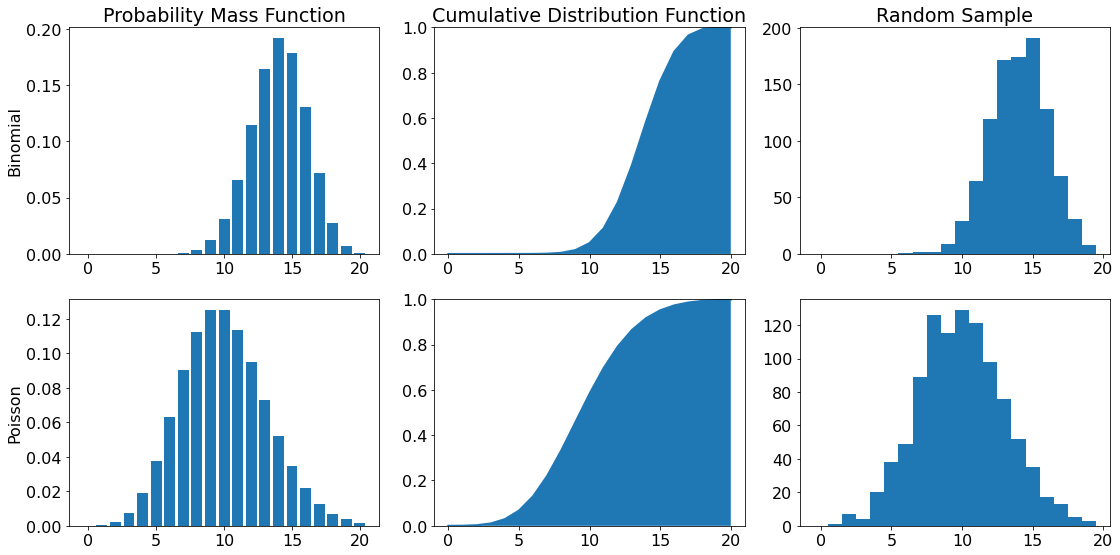

In [88]:
N_SAMPLES = 1000

pds = [('Binomial', stats.binom(20, 0.7), (0., 21.)),
      ('Poisson', stats.poisson(10.), (0., 21.))]

n_pds = len(pds)
fig, ax_list = plt.subplots(n_pds, 3)
fig.set_size_inches((8.*n_pds, 8.))
for ind, elem in enumerate(pds):
    
    pd_name, pd_func, pd_range = elem

    x_range = np.arange(*pd_range)
    
    # Probability Mass Function
    ax_list[ind, 0].bar(x_range, pd_func.pmf(x_range))
    ax_list[ind, 0].set_ylabel(pd_name)
    
    # Cumulative Distribution Function
    ax_list[ind, 1].plot(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].fill_between(x_range, pd_func.cdf(x_range))
    ax_list[ind, 1].set_ylim([0., 1.])
    
    # Random Variable Sample
    ax_list[ind, 2].hist(pd_func.rvs(size=N_SAMPLES), bins=x_range - 0.5)
    
    if ind == 0:
        _ = ax_list[ind, 0].set_title('Probability Mass Function')
        _ = ax_list[ind, 1].set_title('Cumulative Distribution Function')
        _ = ax_list[ind, 2].set_title('Random Sample')
        
plt.tight_layout()

<a id=multivariate_distributions></a>
### Multivariate distributions

In [89]:
# Initialize a multivariate normal distribution
mult_mean = [0.1, 2.]
mult_cov =  [[2.0, 0.3], [0.3, 0.5]]
mult_norm = stats.multivariate_normal(mean=mult_mean, cov=mult_cov)

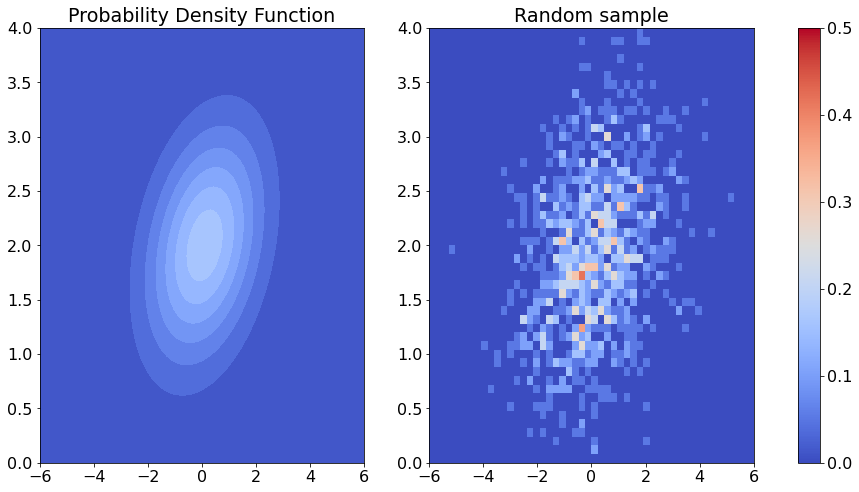

In [90]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

XLIM = [-6., 6.]
YLIM = [0., 4.]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16., 8.))

# Make data.
x = np.linspace(*XLIM, 100)
y = np.linspace(*YLIM, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = mult_norm.pdf(pos)
S = mult_norm.rvs(1000)

color_norm = colors.Normalize(vmin=0, vmax=0.5)

# Contour plot of the PDF
ax1.contourf(X, Y, Z, cmap='coolwarm', norm=color_norm)
ax1.set_title('Probability Density Function')


# 2D histogram of the random sample
h = ax2.hist2d(S[:, 0], S[:, 1], bins=50, density=True, 
               cmap='coolwarm', range=[XLIM, YLIM],
              norm=color_norm)
ax2.set_title('Random sample')

# Add a common color bar
fig.colorbar(h[3], ax=[ax1, ax2]);

<a id=statistical_functions></a>
## Statistical Functions

### Normality test

Used to determine if a sample comes from a normal distribution

In [91]:
x_sample = stats.norm().rvs(size=1000)

alpha = 5e-2

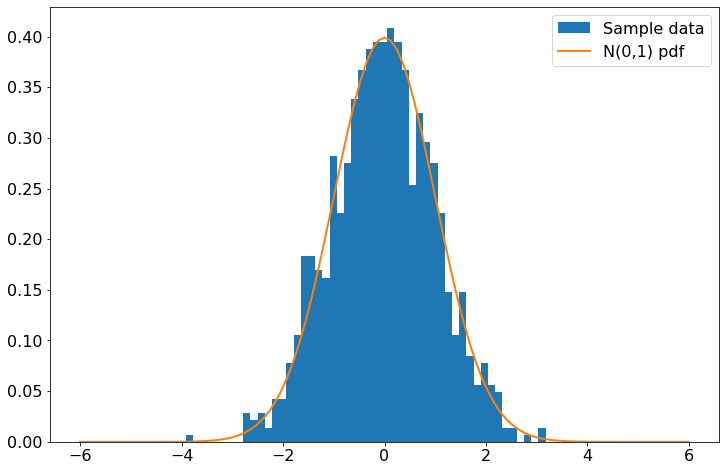

In [92]:
x = np.linspace(-6, 6, 101)
plt.hist(x_sample, bins=50, label='Sample data', density=True);
plt.plot(x, stats.norm().pdf(x), label='N(0,1) pdf')
plt.legend()

Normality test using `normaltest`: Tests if a sample comes from a normal distribution

In [93]:
def print_result(p, alpha):
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")  

In [94]:
k2, p = stats.normaltest(x_sample)
print_result(p, 5e-2)

p = 0.915108
The null hypothesis cannot be rejected


Do the same with some additional noise

In [95]:
w = 3
x_noise = stats.uniform.rvs(loc=np.full_like(x_sample, -w/2), scale=w)

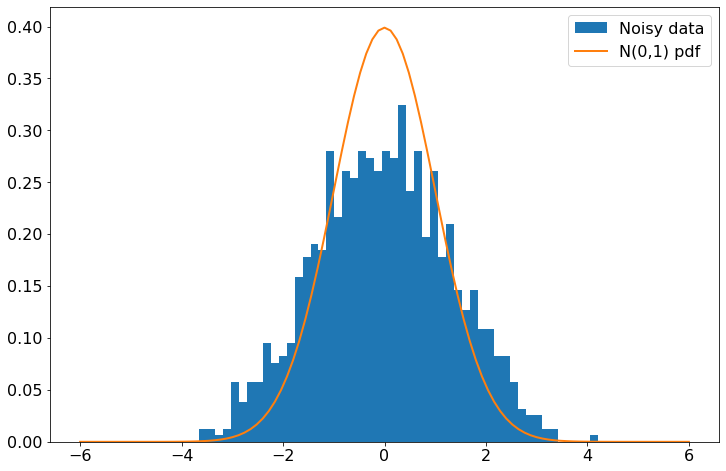

In [96]:
x = np.linspace(-6, 6, 101)
plt.hist(x_sample + x_noise, bins=50, density=True, label='Noisy data');
plt.plot(x, stats.norm().pdf(x), label='N(0,1) pdf')
plt.legend()

In [97]:
k2, p = stats.normaltest(x_sample + x_noise)
print_result(p, alpha)

p = 0.0185441
The null hypothesis can be rejected


### Kolmogorov-Smirnov test

To test if a sample matches a distribution.

In [99]:
x_noisy = x_sample + x_noise
l = x_noise.mean()
s = x_noise.std(ddof=1)
print('loc={} scale={}'.format(l, s))

k, p = stats.kstest(x_sample, stats.norm(l, s).cdf)
print_result(p, alpha)


loc=-0.006597323404061495 scale=0.8779734703751582
p = 0.00892668
The null hypothesis can be rejected


And much more: descriptive functions, more tests, contingency tables,...

See [the docs](https://docs.scipy.org/doc/scipy/reference/stats.html)

<a id=stats_example></a>
## Example

In [100]:
import pandas as pd

alpha = 1e-2
df_prices = pd.read_csv('resources/stock.csv')
df_prices.head(10)

,Date,Apple,Microsoft,Intel,IBM,Facebook,Google
0,2015-12-31,105.260002,55.480000,34.450001,137.619995,104.660004,758.880005
1,2016-01-04,105.349998,54.799999,33.990002,135.949997,102.220001,741.840027
2,2016-01-05,102.709999,55.049999,33.830002,135.850006,102.730003,742.580017
3,2016-01-06,100.699997,54.049999,33.080002,135.169998,102.970001,743.619995
4,2016-01-07,96.449997,52.169998,31.840000,132.860001,97.919998,726.390015
5,2016-01-08,96.959999,52.330002,31.510000,131.630005,97.330002,714.469971
6,2016-01-11,98.529999,52.299999,32.060001,133.229996,97.510002,716.030029
7,2016-01-12,99.959999,52.779999,32.680000,132.899994,99.370003,726.070007
8,2016-01-13,97.389999,51.639999,31.910000,131.169998,95.440002,700.559998
9,2016-01-14,99.519997,53.110001,32.740002,132.910004,98.370003,714.719971


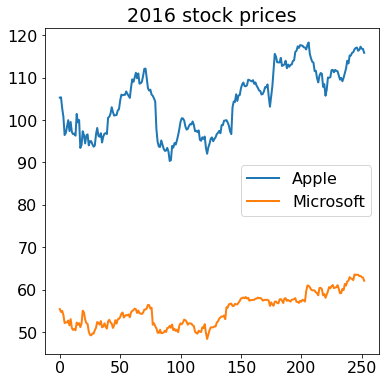

In [101]:
_ = df_prices[['Apple', 'Microsoft']].plot(title='2016 stock prices', figsize=(6., 6.))

In [102]:
# Compute the daily relative increments
df_incs = df_prices.drop('Date', axis=1)
df_incs = ((df_incs - df_incs.shift(1))/df_incs.shift(1)).loc[1:, :]
df_incs['Date'] = df_prices.Date
df_incs.head(10)

,Apple,Microsoft,Intel,IBM,Facebook,Google,Date
1,0.000855,-0.012257,-0.013353,-0.012135,-0.023314,-0.022454,2016-01-04
2,-0.025059,0.004562,-0.004707,-0.000735,0.004989,0.000998,2016-01-05
3,-0.019570,-0.018165,-0.022170,-0.005006,0.002336,0.001400,2016-01-06
4,-0.042205,-0.034783,-0.037485,-0.017090,-0.049043,-0.023170,2016-01-07
5,0.005288,0.003067,-0.010364,-0.009258,-0.006025,-0.016410,2016-01-08
6,0.016192,-0.000573,0.017455,0.012155,0.001849,0.002184,2016-01-11
7,0.014513,0.009178,0.019339,-0.002477,0.019075,0.014022,2016-01-12
8,-0.025710,-0.021599,-0.023562,-0.013017,-0.039549,-0.035134,2016-01-13
9,0.021871,0.028466,0.026011,0.013265,0.030700,0.020212,2016-01-14
10,-0.024015,-0.039917,-0.091020,-0.021669,-0.034563,-0.028361,2016-01-15


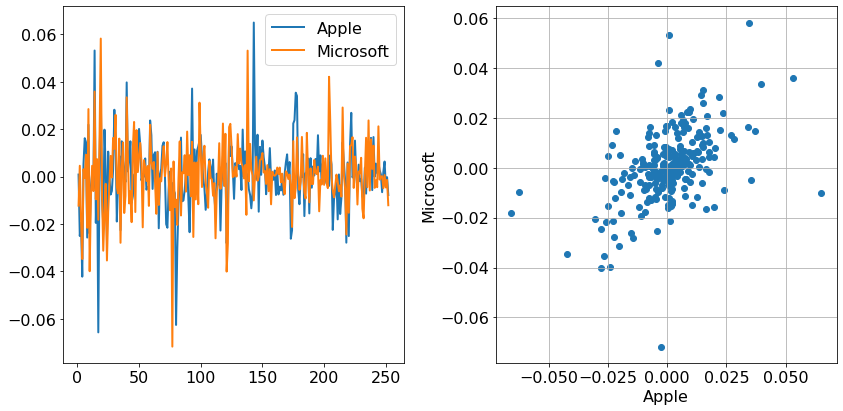

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12., 6.))
_ = df_incs[['Apple', 'Microsoft']].plot(ax=ax1)
_ = ax2.scatter(df_incs['Apple'], df_incs['Microsoft'])
ax2.grid()
ax2.set_xlabel('Apple')
ax2.set_ylabel('Microsoft')
plt.tight_layout()

We can use the `fit` method to MLE of the mean and the std

In [104]:
# we can use the fit method to get the MLE of the mean and the std
p = stats.norm.fit(df_incs.Apple)
print(p)

(0.000487592455494109, 0.014692416094615579)


In [105]:
# Create estimated distributions based on the sample
app_dist = stats.norm(*p)

In [106]:
# We can test if this data fits a normal distribution (Kolmogorov-Smirnov test)
app_K, app_p = stats.kstest(df_incs['Apple'], app_dist.cdf)
print_result(app_p, alpha)

p = 0.02628
The null hypothesis cannot be rejected


<a id=exercise_5></a>
## Exercise 5

Do the same for Microsoft:
* Fit a normal distribution to the data
* Create the instance of the Normal distribution
* Test if the sample comes from this normal distribution

Once you have done this. Here comes the tougher part:

Imagine you are a product designer in a finantial company. You want to create a new investment product to be "sold" to your clients based on the future stock prices of some IT companies. The profit the client gets from his investement is calculated like this:
* At  the time of the investment we check the initial stock prices of Apple and Microsoft
* 12 months later (let's say 240 work days), the client gets 100% of the investement back. Additionally if all stock prices are higher than the initial ones, the client earns half the lowest increment (in %). 

**What is the expected profit of this product?**

<a id=spatial_functions></a>
# Spatial Functions

A complete list of scipy spatial functions can be found [here](https://docs.scipy.org/doc/scipy-1.6.2/reference/tutorial/spatial.html).

## Delaunay triangulation

In [107]:
from scipy.spatial import Delaunay
#points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
points = np.random.rand(6, 2)
tri = Delaunay(points)

(-0.5, 1.5)

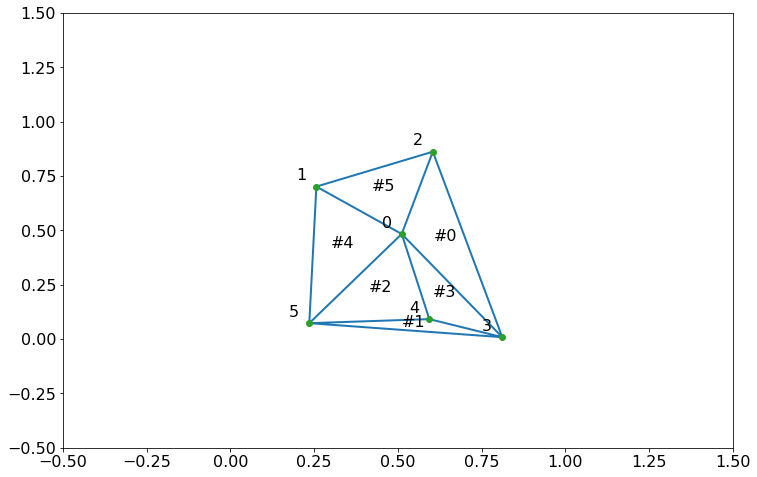

In [108]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], '#%d' % j, ha='center') # label triangles
plt.xlim(-0.5, 1.5); plt.ylim(-0.5, 1.5)

## Convex Hull

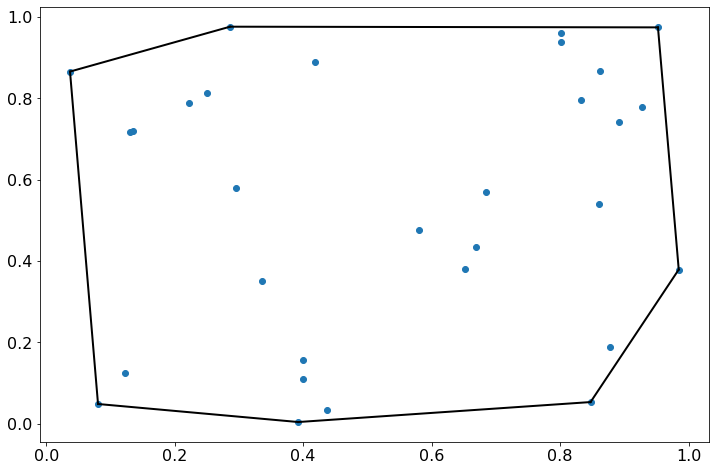

In [109]:
from scipy.spatial import ConvexHull
points = np.random.rand(30, 2)   # 30 random points in 2-D
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')
plt.show()

<a id=special_functions></a>
# Special Functions

A complete list of scipy special functions can be found [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/special.html).

<a id=filtering></a>
# Signal filtering

Consider this noisy data set with outliers. The data is a so-called S-curve, and we want to identify the midpoint of the falling edge.

Real value: 3
Fit value: 3.4755105531755985


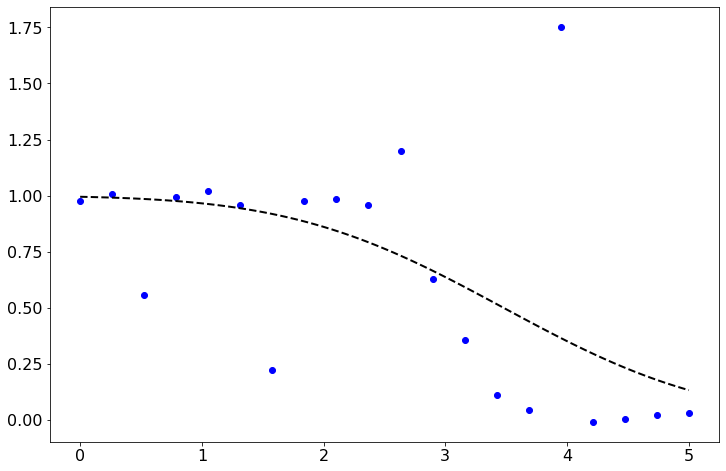

In [110]:
from scipy.special import ndtr

def s_curve(x, a, b):
    return ndtr(-a*(x - b))

# generate mildly noisy data using Gaussian CDF (see end of this notebook)
real_params = [2.5, 3]
x = np.linspace(0, 5, 20)
y = s_curve(x, *real_params)
y += np.random.normal(0, 0.025, len(y))

# add 4 bad data points
outlier_xcoords = [2, 6, 10, 15]
y[outlier_xcoords] = np.random.uniform(0.2, 2, size=4)
plt.plot(x, y, 'bo')

# attempt to fit
params, __ = curve_fit(s_curve, x, y)
z = np.linspace(0, 5, 100)
plt.plot(z, s_curve(z, *params), 'k--')
print('Real value:', real_params[1])
print('Fit value:', params[1])

You can see clearly in the data that the mid-point of the S-curve is at about x=3 (which is the real value), but the outliers destroy the fit. We can remove them easily with a median filter. A median filter is particularly suited to edge detection cases, since it tends to preserve edges well.

Real value: 3
Fit value: 3.037127158939865


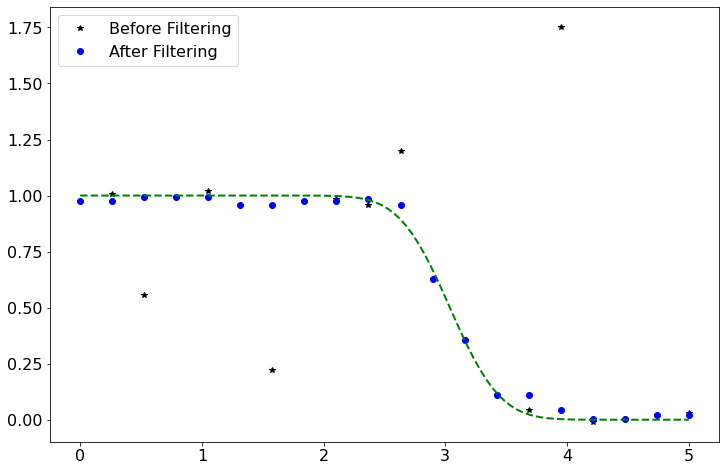

In [111]:
from scipy.signal import medfilt

filtered_y = medfilt(y)

params, __ = curve_fit(s_curve, x, filtered_y)
print('Real value:', real_params[1])
print('Fit value:', params[1])

z = np.linspace(0, 5, 100)
plt.plot(x, y, 'k*', label='Before Filtering')
plt.plot(x, filtered_y, 'bo', label='After Filtering')
plt.plot(z, s_curve(z, *params), 'g--')
plt.legend();

<a id=exercise_6></a>
## Exercise 6

The following is an example implementation of a low-pass [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter):

In [112]:
from scipy.signal import butter, lfilter

def lowpass_filter(data, cutoff, fs, order=5):
    """
    Digital Butterworth low-pass filter.
    
    data   : 1D array of data to be filtered
    cutoff : cutoff frequency in Hz
    fs     : sampling frequency (samples/second)
    """
    nyquist_frequency = fs/2
    normal_cutoff = cutoff/nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='low')
    y = lfilter(b, a, data)
    return y

You are the unfortunate recipient of the following noisy data, which contains noise at two different (unknown) frequencies:

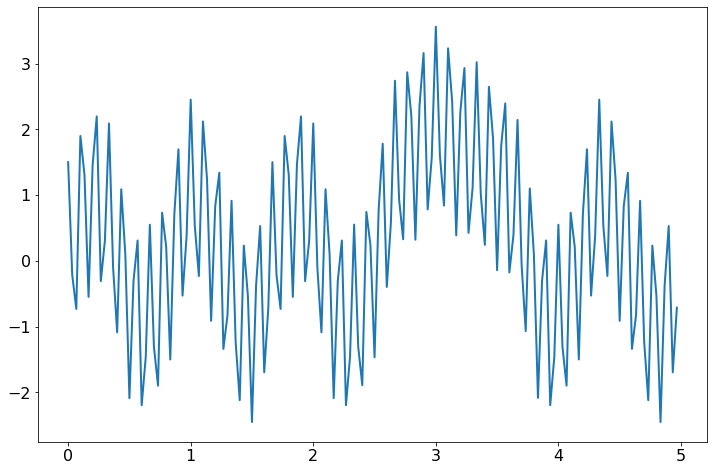

In [113]:
data = np.genfromtxt('resources/scipy_filter_data.dat')
t = data[:, 0]
y = data[:, 1]
sample_freq = (len(t) - 1)/(t[-1])
plt.plot(t, y);   # these are your data

Somewhere in this mess is a Gaussian:

In [114]:
from scipy.stats import norm

def gaussian(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

Use a FFT to identify the two offending noise frequencies. Then convert the `lowpass_filter` above into a bandstop filter (hint: it is a trivial modification), and remove the offending noise from the data as much as possible (it won't be perfect). Finally, use `curvefit` to fit a Gaussian to the data, thereby recovering the original signal.

<a id=bessel></a>
## Bessel functions

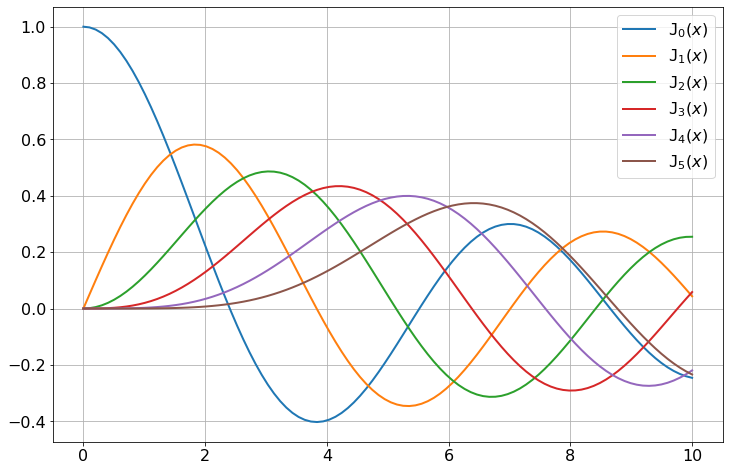

In [115]:
from scipy.special import jn

x = np.linspace(0, 10, 100)
for n in range(6):
    plt.plot(x, jn(n, x), label=r'$\mathtt{J}_{%i}(x)$' % n)
plt.grid()
plt.legend();

/tmp/ipykernel_94/1782896783.py:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = plt3d.Axes3D(fig)


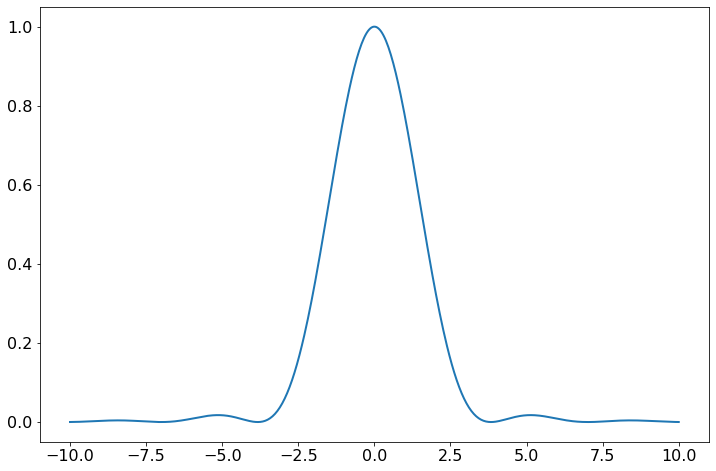

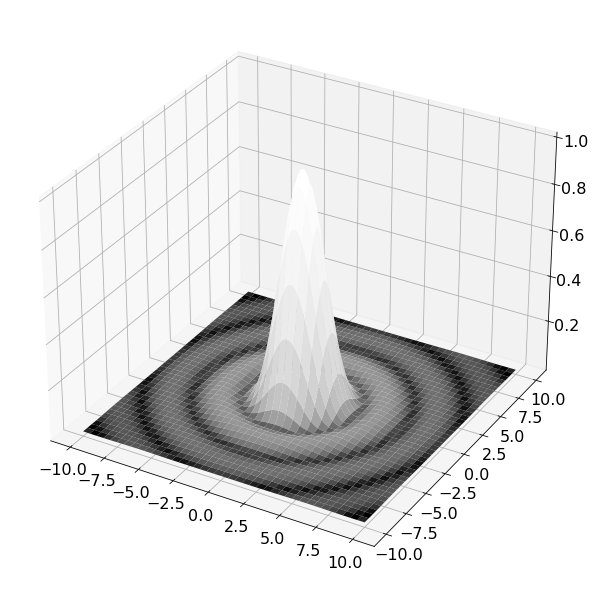

In [116]:
import mpl_toolkits.mplot3d.axes3d as plt3d
from matplotlib.colors import LogNorm

def airy_disk(x):
    mask = x != 0
    result = np.empty_like(x)
    result[~mask] = 1.0
    result[mask] = (2 * jn(1, x[mask]) / x[mask])**2
    return result

# 2D plot
r = np.linspace(-10, 10, 500)
plt.plot(r, airy_disk(r))

# 3D plot
x = np.arange(-10, 10.1, 0.1)
y = np.arange(-10, 10.1, 0.1)

X, Y = np.meshgrid(x, y)
Z = airy_disk(np.sqrt(X**2 + Y**2))

result
fig = plt.figure()
ax = plt3d.Axes3D(fig)
ax.plot_surface(X, Y, Z, cmap='gray', norm=LogNorm(), lw=0)

None

<a id=erf></a>
## Error function and Gaussian CDF

CDF = cumulative distribution function

$$\mathrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^z \exp\left( -t^2 \right) dt $$
$$\mathrm{ndtr}(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^z \exp\left( \frac{-t^2}{2} \right) dt $$

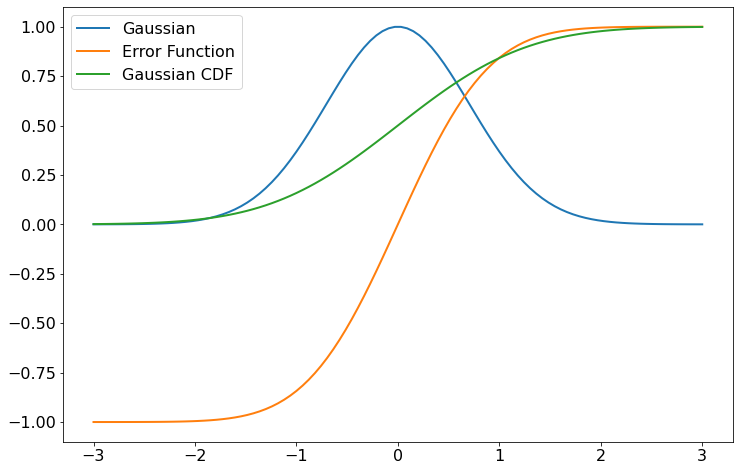

In [117]:
from scipy.special import erf, ndtr

def gaussian(z):
    return np.exp(-z**2)

x = np.linspace(-3, 3, 100)
plt.plot(x, gaussian(x), label='Gaussian')
plt.plot(x, erf(x), label='Error Function')
plt.plot(x, ndtr(x), label='Gaussian CDF')
plt.ylim(-1.1, 1.1)
plt.legend(loc='best');

<a id=ortho_polys></a>
## Orthogonal Polynomials

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_94/3740582087.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is 'Legendre' or 'Chebyshev' in name:


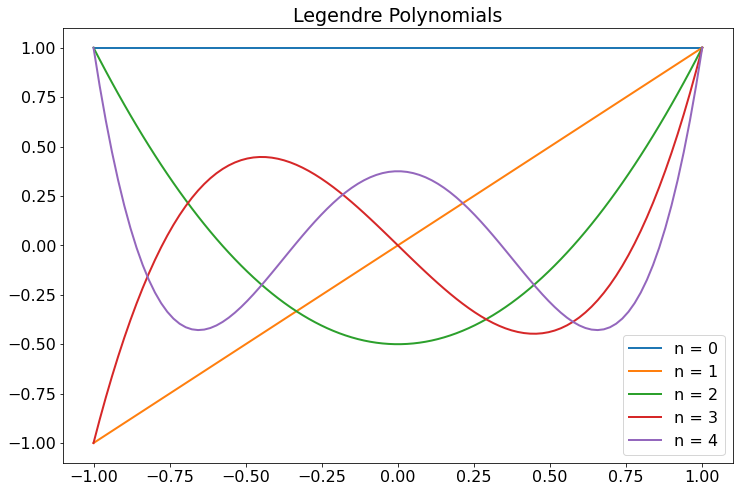

In [118]:
from scipy.special import eval_legendre, eval_laguerre, eval_hermite, eval_chebyt

ortho_poly_dict = {'Legendre': eval_legendre,
                   'Laguerre': eval_laguerre,
                   'Hermite': eval_hermite,
                   'Chebyshev T': eval_chebyt}

def plot_ortho_poly(name):
    plt.figure()
    f = ortho_poly_dict[name]
    x = np.linspace(-1, 1, 100)
    for n in range(5):
        plt.plot(x, f(n, x), label='n = %i' % n)
    if name is 'Legendre' or 'Chebyshev' in name:
        plt.ylim(-1.1, 1.1)
    plt.legend(loc='best', fontsize=16)
    plt.title(name + ' Polynomials')
    
plot_ortho_poly('Legendre')
# plot_ortho_poly('Laguerre')
# plot_ortho_poly('Hermite')
# plot_ortho_poly('Chebyshev T')

<a id=exercise_7></a>
## Exercise 7

Orthogonal polynomials can be used to construct a series expansion of an arbitrary function, just like $\sin$ and $\cos$ are used to construct a Fourier series. For example, we can express a function $f(x)$ as a series of Legendre polynomials $P_n(x)$:

$$ f(x) = \sum_{n=0}^{\infty} a_n P_n(x) $$

The Legendre polynomials are orthogonal on the interval $x \in [-1, 1]$, where they obey the following orthogonality relationship:
$$ \int_{-1}^{1} P_n(x) \, P_m(x) \, dx = \frac{2}{2 m + 1} \delta_{mn} $$

With $f(x) = sin(\pi x)$, write a function to calculate the coefficients $a_n$ of the Legendre series. Then plot $f(x)$ and the Legendre series for $x \in [-1, 1]$. Calculate as many coefficients as are needed for the series to essentially the same as $f(x)$ (it will be less than ten).

If you are struggling with the math, look [here](http://mathworld.wolfram.com/Fourier-LegendreSeries.html).

## Additional information

#### Fitting with (i)minuit

One of the most extended minimization packages classically used for fitting is [MINUIT](https://en.wikipedia.org/wiki/MINUIT). Python allows to use this software via wrapping the C++ code into a python package named [iminuit](https://github.com/iminuit/iminuit).

For more information see [iminuit documentation](http://iminuit.readthedocs.io/en/latest/), and the [available tutorials](https://github.com/iminuit/iminuit/blob/master/tutorial/tutorial.py) within the GitHub project.



